In [2]:
!pip install nltk optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.9 MB/s eta 0:00:00


In [25]:
import pandas as pd
import numpy as np
import warnings
import lightgbm as lgb
import optuna
import nltk
import matplotlib.pyplot as plt
import torch
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

from transformers import AutoModel, AutoTokenizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')

warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Построение модели на основе TF-IDF
## 1.1. Лемматизация и векторизация текстов

In [ ]:
lemmatizer = WordNetLemmatizer()

df10q = pd.read_csv('MDA_dataset_10K.csv', index_col=0)
df10q.dropna(inplace=True)

texts = df10q['MDA'].apply(lambda x: x.split()).tolist()
labels = df10q['target_10_index'].tolist()

filtered_texts = []
filtered_labels = []
for text, label in zip(texts, labels):
    if len(text) > 0:
        filtered_texts.append(text)
        filtered_labels.append(label)

texts = filtered_texts
labels = filtered_labels

lemmatized_texts = []
for text in texts:
    lemmatized_text = []
    for word in text:
        lemmatized_word = lemmatizer.lemmatize(word.lower())
    lemmatized_texts.append(lemmatized_text)

lemmatized_texts_list = [' '.join(text) for text in lemmatized_texts]

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(lemmatized_texts_list)

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, labels, test_size=0.2, random_state=42)

## 1.2. Поиск оптимальных гиперпараметров PCA и LightGBM (Optuna)

In [ ]:
def objective(trial):

    pca_n_components = trial.suggest_uniform('pca_n_components', 0.5, 0.95)

    pca = PCA(n_components=pca_n_components)
    X_train_pca = pca.fit_transform(X_train.toarray())
    X_test_pca = pca.transform(X_test.toarray())

    param = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0)
    }

    lgb_train = lgb.Dataset(X_train_pca, label=y_train)

    gbm = lgb.train(param, lgb_train, num_boost_round=1000)

    y_probs = gbm.predict(X_test_pca, num_iteration=gbm.best_iteration)

    auc = roc_auc_score(y_test, y_probs)
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Best trial:', study.best_trial)
print('Best AUC:', study.best_value)
print('Best hyperparameters:', study.best_params)

[I 2025-03-13 16:02:11,248] A new study created in memory with name: no-name-4362204f-a941-4823-a027-78ff21b2628c
[I 2025-03-13 16:02:57,635] Trial 0 finished with value: 0.5426952336593697 and parameters: {'pca_n_components': 0.8467443296260382, 'num_leaves': 92, 'learning_rate': 0.02918427090415836, 'max_depth': 9, 'min_child_samples': 80, 'lambda_l1': 2.780777438248642, 'lambda_l2': 0.010289610706535663}. Best is trial 0 with value: 0.5426952336593697.
[I 2025-03-13 16:03:20,490] Trial 1 finished with value: 0.5996739636702375 and parameters: {'pca_n_components': 0.6124688126692582, 'num_leaves': 129, 'learning_rate': 0.003278411696142187, 'max_depth': 6, 'min_child_samples': 79, 'lambda_l1': 0.5966741216347178, 'lambda_l2': 0.00018724118527504966}. Best is trial 1 with value: 0.5996739636702375.
[I 2025-03-13 16:03:45,072] Trial 2 finished with value: 0.5636547120012421 and parameters: {'pca_n_components': 0.8597869984007521, 'num_leaves': 60, 'learning_rate': 0.1832197259066776, '

Best trial: FrozenTrial(number=21, state=1, values=[0.6402344356466387], datetime_start=datetime.datetime(2025, 3, 13, 16, 11, 32, 83346), datetime_complete=datetime.datetime(2025, 3, 13, 16, 11, 53, 582598), params={'pca_n_components': 0.5606855688634134, 'num_leaves': 95, 'learning_rate': 0.00152034285182398, 'max_depth': 5, 'min_child_samples': 60, 'lambda_l1': 1.0934156036200342e-08, 'lambda_l2': 1.1445516337375753e-07}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pca_n_components': FloatDistribution(high=0.95, log=False, low=0.5, step=None), 'num_leaves': IntDistribution(high=150, log=False, low=20, step=1), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.001, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_samples': IntDistribution(high=100, log=False, low=1, step=1), 'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=True, low=1e-

Наиболее ресурсозатратная операция в обучении - подбор гиперпараметров PCA. По итогам оптимизации установлено, что оптимальное значение доли дисперсии PCA лежит в диапазоне 0.55-0.68.   
Наилучшее качество модели на TF-IDF по ROC-AUC составило 0.64, что в целом не является существенным приростом к предыдущей модели (0.62). Попробуем изменить подход к векторизации и использовать трансформеры.

# 2. Построение модели с использованием трансформеров (FinBERT)

In [9]:
device = torch.device("cuda")

df10q = pd.read_csv('MDA_dataset_10K.csv', index_col=0)
df10q.dropna(inplace=True)

texts = df10q['MDA'].tolist()
labels = df10q['target_10_index'].tolist()

start_text = 1500 # best 1500

processed_texts = []
processed_labels = []
for text, label in zip(texts, labels):
    if len(text) > 0:
        if len(text) >= start_text:
            processed_text = text[start_text:]
        else:
            processed_text = text
        processed_texts.append(processed_text)
        processed_labels.append(label)

texts = processed_texts
labesls = processed_labels

tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model = AutoModel.from_pretrained('ProsusAI/finbert')

model.to(device)

def get_text_embedding(text):
    inputs = tokenizer(
        text,
        return_tensors='pt',
        max_length=512,
        padding='max_length',
        truncation=True
    ).to(device)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings.detach().cpu().numpy()[0]

vectors = [get_text_embedding(text) for text in texts]

X_train, X_test, y_train, y_test = train_test_split(vectors, labels, test_size=0.2, random_state=42)

In [21]:
pca = PCA(n_components=0.865) # best 0.865 auc 0.685 #100 итераций
X_train_pca = pca.fit_transform(np.array(X_train))
X_test_pca = pca.transform(np.array(X_test))

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0)
    }

    lgb_train = lgb.Dataset(X_train_pca, label=y_train)

    gbm = lgb.train(param, lgb_train, num_boost_round=1000)

    y_probs = gbm.predict(X_test_pca, num_iteration=gbm.best_iteration)

    auc = roc_auc_score(y_test, y_probs)
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

print('Best trial:', study.best_trial)
print('Best AUC:', study.best_value)
print('Best hyperparameters:', study.best_params)

[I 2025-03-14 09:12:30,567] A new study created in memory with name: no-name-3fc242ea-bd6a-48e8-9114-ae13305bd0df
[I 2025-03-14 09:12:32,642] Trial 0 finished with value: 0.649472131656575 and parameters: {'num_leaves': 32, 'learning_rate': 0.003960283871881636, 'max_depth': 6, 'min_child_samples': 99, 'lambda_l1': 0.09022975989721964, 'lambda_l2': 9.071377833824926e-05}. Best is trial 0 with value: 0.649472131656575.
[I 2025-03-14 09:12:43,317] Trial 1 finished with value: 0.6115510013972986 and parameters: {'num_leaves': 64, 'learning_rate': 0.04295678950952833, 'max_depth': 9, 'min_child_samples': 67, 'lambda_l1': 0.0007964675522008699, 'lambda_l2': 3.7859606464759834e-08}. Best is trial 0 with value: 0.649472131656575.
[I 2025-03-14 09:12:45,071] Trial 2 finished with value: 0.5849247011333644 and parameters: {'num_leaves': 34, 'learning_rate': 0.13493445968687137, 'max_depth': 4, 'min_child_samples': 59, 'lambda_l1': 6.421029165326149e-05, 'lambda_l2': 4.4059720131856646e-05}. Bes

Best trial: FrozenTrial(number=369, state=1, values=[0.6905759975159137], datetime_start=datetime.datetime(2025, 3, 14, 9, 19, 43, 59608), datetime_complete=datetime.datetime(2025, 3, 14, 9, 19, 45, 364993), params={'num_leaves': 134, 'learning_rate': 0.00602890546480639, 'max_depth': 8, 'min_child_samples': 60, 'lambda_l1': 4.557432101977079e-05, 'lambda_l2': 0.0024408447030333067}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=150, log=False, low=20, step=1), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.001, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_samples': IntDistribution(high=100, log=False, low=1, step=1), 'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=True, low=1e-08, step=None)}, trial_id=369, value=None)
Best AUC: 0.6905759975159137
Best hyperparameters: {'num_leaves': 134, 'learning

Модель на трансформерах показала наилучшие результаты. ROC-AUC вырос до 0.69, что является существенным приростом к предыдущему чекпоинту (0.62)

# 3. Обучение модели с лучшими гиперпараметрами.

In [22]:
best_params = study.best_params
best_params['objective'] = 'binary'
best_params['metric'] = 'auc'
best_params['boosting_type'] = 'gbdt'
best_params['verbosity'] = -1

lgb_train = lgb.Dataset(X_train_pca, label=y_train)
best_gbm = lgb.train(best_params, lgb_train, num_boost_round=1000)

y_probs_best = best_gbm.predict(X_test_pca, num_iteration=best_gbm.best_iteration)

auc_best = roc_auc_score(y_test, y_probs_best)
print('AUC лучшей модели на тестовом наборе:', auc_best)

AUC лучшей модели на тестовом наборе: 0.6905759975159137


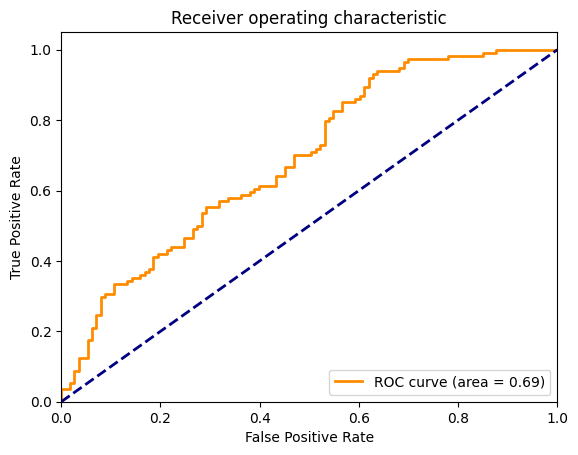

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs_best)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [26]:
with open('best_model_and_pca.pkl', 'wb') as file:
    pickle.dump((best_gbm, pca), file)

# with open('best_model_and_pca.pkl', 'rb') as file:
#     loaded_gbm, loaded_pca = pickle.load(file)